In [ ]:
pip install datasets

In [ ]:
import os
from datasets import load_dataset

token = os.getenv('HF_TOKEN')
ds_100k = load_dataset("GGmorello/FLAMES_results", "100k", token=token)
#ds = load_dataset('GGmorello/FLAMES', 'infilled', split='train[:10000]', token=token, cache_dir='/Users/mojtabaeshghie/.cache/hf')#, num_proc=8)

In [ ]:
ds_llama = load_dataset("GGmorello/FLAMES_results", "default", token=token)

In [ ]:
ds_20k = load_dataset("GGmorello/FLAMES_results", "20k", token=token)

In [ ]:
df_100k = ds_100k['train'].to_pandas()
df_llama = ds_llama['train'].to_pandas()
df_20k = ds_20k['train'].to_pandas()

In [ ]:
df_100k

In [ ]:
pip install sindi

In [ ]:
from sindi import Comparator, ComparatorRulesOnly

In [ ]:
from sindi.comparator import Comparator
comparator = Comparator()

In [ ]:
print(df_100k['predicate'][0])
print(df_100k['results'][0])
comparator.compare(df_100k['label'][0], df_100k['results'][0])

## Evaluating 100k set

In [ ]:
head_100 = df_100k.head(5000)
head_100

In [ ]:
from tqdm import tqdm

head_100 = df_100k.head(5000)
sindi_failures = []
comparison_results = []
for i, row in tqdm(df_100k.iterrows(), total=len(df_100k)):
    ground_truth = row['predicate']
    synthesized = row['results']

    # test for exact string match between two predicates (first strip them out of any leading/trailing whitespaces)
    if ground_truth.strip() == synthesized.strip():
        comparison_results.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': 'Exact Match'}) 
        continue
    
    # if not exact match, we will use predi to compare the two predicates
    try:
        result = comparator.compare(ground_truth, synthesized)
        comparison_results.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': result})        
        #print(f"({i}) For predicates {pred1} ************* {pred2} ############## {result}")
    except Exception as e:
        comparison_results.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': 'The predicates are not equivalent and neither is stronger.'})
        sindi_failures.append(({'index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'exception': e}))
        continue


In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Assuming 'comparison_results' is already defined and is a DataFrame
data = pd.DataFrame.from_dict(comparison_results[0:5000])

# Calculate the result distribution
result_distribution = data['result'].value_counts()

# Define the updated color palette and use a pattern for the "Exact Match" bar
color_map_updated = {
    "The predicates are not equivalent and neither is stronger.": "#8c8c8c",
    "Exact Match": "#66c2a5",
    "The predicates are equivalent.": "#2ca25f",
    "The second predicate is stronger.": "#fc8d62",
    "The first predicate is stronger.": "#8da0cb"
}

# Create the bar plot with the updated color scheme and add patterns for specified bars
plt.figure(figsize=(6, 4))
bars = plt.bar(result_distribution.index, result_distribution.values, color=[color_map_updated.get(result, 'gray') for result in result_distribution.index])

# Add patterns to the "Exact Match" and "The predicates are equivalent." bars
for bar, label in zip(bars, result_distribution.index):
    if label == "Exact Match":
        bar.set_hatch('//')
    elif label == "The predicates are equivalent.":
        bar.set_hatch('xx')

# Adjust the y-axis limits to add space above the bars
plt.ylim(0, max(result_distribution.values) * 1.1)

# Add numbers on top of the bars with a smaller font size
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (max(result_distribution.values) * 0.02), int(yval), ha='center', va='bottom', fontsize=10)

# Set the labels with specified font sizes
plt.xlabel('Result', fontsize=11)
plt.ylabel('Count', fontsize=11)

# Remove x labels and add a legend below the plot with specified font size and updated labels
plt.xticks([])
legend_labels = [
    mpatches.Patch(color="#8c8c8c", label="The predicates are not equivalent and neither is stronger."),
    mpatches.Patch(facecolor="#66c2a5", hatch='//', label="Exact match"),
    mpatches.Patch(facecolor="#2ca25f", hatch='xx', label="The predicates are equivalent."),
    mpatches.Patch(color="#fc8d62", label="The synthesized is stronger."),
    mpatches.Patch(color="#8da0cb", label="Ground truth is stronger.")
]
plt.legend(handles=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1, fontsize=10)

# Adjust layout and save the plot as PDF with a suitable size for ACM papers
plt.tight_layout()
plt.savefig('match_results_distribution_acm.pdf')
plt.show()


## Evaluating 20k

In [ ]:
from tqdm import tqdm
import re

head_100 = df_20k.head(5000)
sindi_failures_20k = []
comparison_results_20k = []
for i, row in tqdm(df_20k.head(5000).iterrows(), total=5000):
    ground_truth = row['predicate']
    synthesized = row['results']

    synthesized = re.sub(r',\s*".*$', '', synthesized)


    # test for exact string match between two predicates (first strip them out of any leading/trailing whitespaces)
    if ground_truth.strip() == synthesized.strip():
        comparison_results_20k.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': 'Exact Match'}) 
        continue
    
    # if not exact match, we will use predi to compare the two predicates
    try:
        result = comparator.compare(ground_truth, synthesized)
        comparison_results_20k.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': result})        
        #print(f"({i}) For predicates {pred1} ************* {pred2} ############## {result}")
    except Exception as e:
        comparison_results_20k.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': 'The predicates are not equivalent and neither is stronger.'})
        sindi_failures_20k.append(({'index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'exception': e}))
        continue


In [ ]:
comparison_results_20k[0:5000][-1]

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Assuming 'comparison_results' is already defined and is a DataFrame
data = pd.DataFrame.from_dict(comparison_results_20k[0:5000])

# Calculate the result distribution
result_distribution_20k = data['result'].value_counts()

# Define the updated color palette and use a pattern for the "Exact Match" bar
color_map_updated = {
    "The predicates are not equivalent and neither is stronger.": "#8c8c8c",
    "Exact Match": "#66c2a5",
    "The predicates are equivalent.": "#2ca25f",
    "The second predicate is stronger.": "#fc8d62",
    "The first predicate is stronger.": "#8da0cb"
}

# Create the bar plot with the updated color scheme and add patterns for specified bars
plt.figure(figsize=(6, 4))
bars = plt.bar(result_distribution_20k.index, result_distribution_20k.values, color=[color_map_updated.get(result, 'gray') for result in result_distribution_20k.index])

# Add patterns to the "Exact Match" and "The predicates are equivalent." bars
for bar, label in zip(bars, result_distribution_20k.index):
    if label == "Exact Match":
        bar.set_hatch('//')
    elif label == "The predicates are equivalent.":
        bar.set_hatch('xx')

# Adjust the y-axis limits to add space above the bars
plt.ylim(0, max(result_distribution_20k.values) * 1.1)

# Add numbers on top of the bars with a smaller font size
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (max(result_distribution_20k.values) * 0.02), int(yval), ha='center', va='bottom', fontsize=10)

# Set the labels with specified font sizes
plt.xlabel('Result', fontsize=11)
plt.ylabel('Count', fontsize=11)

# Remove x labels and add a legend below the plot with specified font size and updated labels
plt.xticks([])
legend_labels = [
    mpatches.Patch(color="#8c8c8c", label="The predicates are not equivalent and neither is stronger."),
    mpatches.Patch(facecolor="#66c2a5", hatch='//', label="Exact match"),
    mpatches.Patch(facecolor="#2ca25f", hatch='xx', label="The predicates are equivalent."),
    mpatches.Patch(color="#fc8d62", label="The synthesized is stronger."),
    mpatches.Patch(color="#8da0cb", label="Ground truth is stronger.")
]
plt.legend(handles=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1, fontsize=10)

# Adjust layout and save the plot as PDF with a suitable size for ACM papers
plt.tight_layout()
plt.savefig('match_results_distribution_acm_20k.pdf')
plt.show()

## Evaluating Llama

In [ ]:
from tqdm import tqdm
import pandas as pd
import re

# Assuming df_llama is already defined and has the columns 'predicate' and 'results CodeLLama'

# Define the regex pattern for predicate extraction
pattern = r"(require\()?([^;,\"']+?)\s*(,|\);|;|$)"

# Function to extract predicates using regex
def extract_predicate(text):
    # Simplify text to handle edge cases like new lines and comments
    text = re.sub(r"//.*", "", text)  # Remove inline comments
    matches = re.search(pattern, text.replace('\n', ' '))
    if matches:
        return matches.group(2).strip()
    return None

# Update the dataframe to include 'synthesized' column from 'results CodeLLama'
df_llama['synthesized'] = df_llama['results CodeLLama'].apply(extract_predicate)

# Comparison logic
sindi_failures_llama = []
comparison_results_llama = []
for i, row in tqdm(df_llama[0:5000].iterrows(), total=5000):
    ground_truth = row['predicate']
    synthesized = row['synthesized']

    if synthesized is None or ground_truth is None or synthesized == '' or ground_truth == '':
        sindi_failures_llama.append({'index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'exception': 'No predicate found in the synthesized code.'})
        continue
    
    # Test for exact string match between two predicates (first strip them out of any leading/trailing whitespaces)
    if ground_truth.strip() == synthesized.strip():
        comparison_results_llama.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': 'Exact Match'})
        continue
    
    # If not exact match, use another method to compare the two predicates
    try:
        result = comparator.compare(ground_truth, synthesized)
        comparison_results_llama.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': result})
        # Uncomment the print line below for detailed debug output
        # print(f"({i}) For predicates {ground_truth} ************* {synthesized} ############## {result}")
    except Exception as e:
        comparison_results_llama.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': 'The predicates are not equivalent and neither is stronger.'})
        sindi_failures_llama.append({'index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'exception': e})
        continue

In [ ]:
df_llama[1999:5000].head()

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Assuming 'comparison_results' is already defined and is a DataFrame
data = pd.DataFrame.from_dict(comparison_results_llama[0:5000])

# Calculate the result distribution
result_distribution_llama = data['result'].value_counts()

# Define the updated color palette and use a pattern for the "Exact Match" bar
color_map_updated = {
    "The predicates are not equivalent and neither is stronger.": "#8c8c8c",
    "Exact Match": "#66c2a5",
    "The predicates are equivalent.": "#2ca25f",
    "The second predicate is stronger.": "#fc8d62",
    "The first predicate is stronger.": "#8da0cb"
}

# Create the bar plot with the updated color scheme and add patterns for specified bars
plt.figure(figsize=(6, 4))
bars = plt.bar(result_distribution_llama.index, result_distribution_llama.values, color=[color_map_updated.get(result, 'gray') for result in result_distribution_llama.index])

# Add patterns to the "Exact Match" and "The predicates are equivalent." bars
for bar, label in zip(bars, result_distribution_llama.index):
    if label == "Exact Match":
        bar.set_hatch('//')
    elif label == "The predicates are equivalent.":
        bar.set_hatch('xx')

# Adjust the y-axis limits to add space above the bars
plt.ylim(0, max(result_distribution_llama.values) * 1.1)

# Add numbers on top of the bars with a smaller font size
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (max(result_distribution_llama.values) * 0.02), int(yval), ha='center', va='bottom', fontsize=10)

# Set the labels with specified font sizes
plt.xlabel('Result', fontsize=11)
plt.ylabel('Count', fontsize=11)

# Remove x labels and add a legend below the plot with specified font size and updated labels
plt.xticks([])
legend_labels = [
    mpatches.Patch(color="#8c8c8c", label="The predicates are not equivalent and neither is stronger."),
    mpatches.Patch(facecolor="#66c2a5", hatch='//', label="Exact match"),
    mpatches.Patch(facecolor="#2ca25f", hatch='xx', label="The predicates are equivalent."),
    mpatches.Patch(color="#fc8d62", label="The synthesized is stronger."),
    mpatches.Patch(color="#8da0cb", label="Ground truth is stronger.")
]
plt.legend(handles=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1, fontsize=10)

# Adjust layout and save the plot as PDF with a suitable size for ACM papers
plt.tight_layout()
plt.savefig('match_results_distribution_acm_llama.pdf')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib as mpl

# Categories
categories = [
    "Not Equivalent\n(No Ordering)", 
    "Exact Match", 
    "Semantically\nEquivalent", 
    "Synthesized\nStronger", 
    "GT\nStronger"
]

# Data
code_llama = [3363, 959, 217, 81, 76]
flames_2ok = [3142, 1328, 362, 94, 74]
flames_100k = [2595, 1840, 334, 125, 106]

x = np.arange(len(categories))
width = 0.23

# Professional color palette (colorblind-friendly)
colors = ['#4E79A7', '#F28E2B', '#59A14F']
hatches = ['///', '\\\\\\', 'xxx']

# Plot
fig, ax = plt.subplots(figsize=(3.45, 2.8))  # Fit into one IEEE column

bars1 = ax.bar(x - width, code_llama, width, label='CodeLlama', color=colors[0], hatch=hatches[0], edgecolor='black', linewidth=0.7)
bars2 = ax.bar(x, flames_2ok, width, label='FLAMES-20k', color=colors[1], hatch=hatches[1], edgecolor='black', linewidth=0.7)
bars3 = ax.bar(x + width, flames_100k, width, label='FLAMES-100k', color=colors[2], hatch=hatches[2], edgecolor='black', linewidth=0.7)

# Axes settings
ax.set_ylabel('Count', fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# Legend
legend_patches = [
    mpatches.Patch(facecolor=colors[i], hatch=hatches[i], edgecolor='black', label=label)
    for i, label in enumerate(['CodeLlama', 'FLAMES-20k', 'FLAMES-100k'])
]
ax.legend(handles=legend_patches, fontsize=8, loc='upper right', frameon=False)

fig.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Categories
categories = [
    "Inconclusive", 
    "Exact Match", 
    "Semantically \nEquivalent", 
    "Synthesized \nStronger", 
    "GT Stronger"
]

# Data
code_llama = [3363, 959, 217, 81, 76]
flames_2ok = [3142, 1328, 362, 94, 74]
flames_100k = [2595, 1840, 334, 125, 106]

x = np.arange(len(categories))
width = 0.23

# Colors: blue for CodeLlama, green shades for FLAMES
colors = ['#4E79A7', '#7FBF7F', '#2C7C2C']  # Blue, light green, dark green
hatches = ['xxx', '\\\\', '']

# Plot
#fig, ax = plt.subplots(figsize=(3.45, 2.8))  # IEEE column size
fig, ax = plt.subplots(figsize=(4.5, 3))  # IEEE column size


bars1 = ax.bar(x - width, code_llama, width, label='CodeLlama', color=colors[0], hatch=hatches[0], edgecolor='black', linewidth=0.7)
bars2 = ax.bar(x, flames_2ok, width, label='FLAMES-20k', color=colors[1], hatch=hatches[1], edgecolor='black', linewidth=0.7)
bars3 = ax.bar(x + width, flames_100k, width, label='FLAMES-100k', color=colors[2], hatch=hatches[2], edgecolor='black', linewidth=0.7)


# Axes settings
ax.set_ylabel('Count', fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=9, rotation=30, ha='right')
ax.tick_params(axis='y', labelsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# Legend
legend_patches = [
    mpatches.Patch(facecolor=colors[i], hatch=hatches[i], edgecolor='black', label=label)
    for i, label in enumerate(['CodeLlama', 'FLAMES-20k', 'FLAMES-100k'])
]
ax.legend(handles=legend_patches, fontsize=9, loc='upper right', frameon=False)
fig.savefig("predicate_comparison.pdf", format="pdf", bbox_inches="tight")

fig.tight_layout()
plt.show()



# 🔌 DeepSeek‑V3 Integration (API Upper-Bound Baseline)

This section adds **DeepSeek‑V3 / V3.1** (model id `deepseek-chat`) to the pipeline for **predicate synthesis** (RQ1 analogue) using either **FIM** (prefix/suffix) or **chat** prompts, then evaluates with your existing comparator.


In [ ]:
pip install openai

In [ ]:

# %% DeepSeek setup (OpenAI-compatible)
# pip install openai       # <- uncomment if needed in your environment
import os, time, re, math, json
from typing import Optional, Dict, Any
try:
    from openai import OpenAI
except Exception as e:
    raise RuntimeError("Install the OpenAI SDK first: pip install openai") from e

# Use the official endpoint (OpenAI-compatible). For FIM beta, set base_url to https://api.deepseek.com/beta
DEEPSEEK_BASE_URL = os.getenv("DEEPSEEK_BASE_URL", "https://api.deepseek.com")
#DEEPSEEK_API_KEY  = os.getenv("DEEPSEEK_API_KEY")  
DEEPSEEK_API_KEY = "..." # :)
if not DEEPSEEK_API_KEY:
    raise RuntimeError("Please set DEEPSEEK_API_KEY as an environment variable.")

client = OpenAI(api_key=DEEPSEEK_API_KEY, base_url=DEEPSEEK_BASE_URL)

# NOTE: DeepSeek docs: https://api-docs.deepseek.com  (OpenAI-compatible API)
# - Chat: client.chat.completions.create(model="deepseek-chat", ...)
# - FIM (beta): base_url='https://api.deepseek.com/beta', client.completions.create(model="deepseek-chat", prompt=prefix, suffix=suffix, ...)


In [2]:
pip install openai

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 948 kB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 444 kB 70.4 MB/s eta 0:00:01
     |████████████████████████████████| 109 kB 77.1 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 305 kB 75.8 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 26.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.9 MB 77.1 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %% DeepSeek setup (OpenAI-compatible)
import os, time, re, json
from typing import Optional
from openai import OpenAI

# IMPORTANT: use OpenAI-compatible IDs
MODEL_CHAT = os.getenv("DEEPSEEK_MODEL", "deepseek-chat")  # or "deepseek-reasoner"
#MODEL_CHAT_V3 = "deepseek-chat-v3-0324"
MODEL_CHAT_V3 = "deepseek-chat" 

DEEPSEEK_API_KEY = "..." 


# Chat/completions (standard)
client = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com")
# FIM (prefix/suffix) lives on the beta endpoint
fim_client = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com/beta")


In [14]:
PREDICATE_REGEX = re.compile(r"require\s*\(\s*(.*?)\s*\)\s*;?\s*$")

def extract_predicate(text: str) -> Optional[str]:
    """Extract a plausible Solidity predicate without truncating at ')'. """
    if not text:
        return None
    line = text.strip()
    # strip backticks if present
    line = re.sub(r"^`+|`+$", "", line).strip()

    # Case 1: model returned a full require(...)
    m = PREDICATE_REGEX.search(line)
    if m:
        return m.group(1).strip()

    # Case 2: model returned just the predicate
    # Only trim a trailing semicolon; DO NOT split on ')'
    line = line.rstrip(";").strip()
    # Optional: if it accidentally starts with 'require(' strip that prefix
    if line.lower().startswith("require(") and line.endswith(")"):
        inner = line[len("require("):-1].strip()
        return inner or None
    return line or None


def backoff_sleep(attempt:int):
    time.sleep(min(2**attempt * 0.5, 10.0))

In [15]:
def deepseek_fim(prefix: str, suffix: str, *, max_tokens:int=128, temperature:float=0.8, top_p:float=0.95) -> str:
    """Use FIM to complete the masked predicate between prefix and suffix."""
    # Choose conservative stops: usually none, or only newline.
    # The suffix already anchors the completion to end before the message/closing paren.
    stops = None  # or: ["\n"] if you prefer single-line output

    for attempt in range(6):
        try:
            resp = fim_client.completions.create(
                model=MODEL_CHAT,        # "deepseek-chat"
                prompt=prefix,
                suffix=suffix,
                max_tokens=max_tokens,
                temperature=temperature,
                top_p=top_p,
                stop=stops,
            )
            text = resp.choices[0].text
            # Do minimal cleanup; don't chop at ')'
            text = text.strip().splitlines()[0]
            return extract_predicate(text) or text
        except Exception as e:
            if attempt >= 5:
                raise
            backoff_sleep(attempt)
    raise RuntimeError("FIM generation failed after retries.")


In [16]:
# %% DeepSeek chat-based generator
DEEPSEEK_SYSTEM = (
    "You are an expert Solidity assistant. When asked to fill a missing predicate, "
    "return EITHER a single line 'require(<predicate>);' OR just the predicate expression. No explanations."
)

FEW_SHOT = [
    {"role":"user", "content": "Fill the missing predicate in: require(<FILL_ME>); Context: function transfer(address to, uint value) external { require(<FILL_ME>); balances[msg.sender]-=value; balances[to]+=value; }"},
    {"role":"assistant", "content": "balances[msg.sender] >= value"},
    {"role":"user", "content": "Fill the missing predicate in: require(<FILL_ME>); Context: function setOwner(address newOwner) external { require(<FILL_ME>); owner = newOwner; }"},
    {"role":"assistant", "content": "msg.sender == owner"},
]

def deepseek_chat(prompt: str, *, max_tokens:int=64, temperature:float=0.8, top_p:float=0.95) -> str:
    for attempt in range(6):
        try:
            resp = client.chat.completions.create(
                model=MODEL_CHAT_V3,  # "deepseek-chat"
                messages=[
                    {"role":"system", "content": DEEPSEEK_SYSTEM},
                    *FEW_SHOT,
                    {"role":"user", "content": prompt},
                ],
                temperature=temperature,
                top_p=top_p,
                max_tokens=max_tokens,
                stop=[");", "\n"]   # stop after first predicate line
            )
            msg = resp.choices[0].message.content
            return extract_predicate(msg) or msg.strip()
        except Exception:
            if attempt >= 5:
                raise
            backoff_sleep(attempt)
    raise RuntimeError("Chat generation failed after retries.")


In [17]:
import pandas as pd
df_disl_hardinv = pd.read_csv('disl-hardinv.csv')

In [18]:
df_disl_hardinv

,Unnamed: 0,comment,input,label,original_idx,predicate,len,results,hardness
0,2827,'INCONSISTENT_PARAMS',// SPDX-License-Identifier: agpl-3.0\npragma s...,assets.length==decodedParams.assetToSwapToList...,352325,assets.length==decodedParams.assetToSwapToList...,-482,assets.length==decodedParams.assetToSwapToList...,42.42
1,4510,"""New balance would exceed the max wallet size.""",// SPDX-License-Identifier: MIT\npragma solidi...,_balances[to].add(amount)<=_maxWalletSize||(fr...,229336,_balances[to].add(amount)<=_maxWalletSize||(fr...,-153,!inSwap,34.63
2,2065,'Treasury: need more permission',pragma solidity ^0.6.0;\nimport '@openzeppelin...,IStandAsset(cash).operator()==address(this)&&I...,320984,IStandAsset(cash).operator()==address(this)&&I...,-181,msg.sender==operator,32.71
3,4306,"""DInterest: An input address is not a contract""",pragma solidity 0.5.17;\npragma experimental A...,_moneyMarket.isContract()&&_stablecoin.isContr...,31013,_moneyMarket.isContract()&&_stablecoin.isContr...,-211,_moneyMarket.isContract()&&_stablecoin.isContr...,31.31
4,1406,NaN,pragma solidity ^0.4.16;\r\n// ERC20 Smartcont...,(balances[msg.sender]>=_value)&&(_value>0)&&(_...,274727,(balances[msg.sender]>=_value)&&(_value>0)&&(_...,-134,balances[msg.sender]>=_value&&_value>0,31.12
...,...,...,...,...,...,...,...,...,...
4995,1627,"""Tree already exists.""",// SPDX-License-Identifier: GPL-3.0\r\npragma ...,"tree.K==0,""Tree already exists.""",358460,tree.K==0,-9,tree.K==0,0.39
4996,775,"""Not open""",// SPDX-License-Identifier: unlicensed\r\nprag...,"e.isOpen,""Not open""",62401,e.isOpen,-8,e.isOpen,0.38
4997,2573,"""MAX_TX_EXCEEDED""",/**\n * ShibUtility | SHIBU\n *\n * Total Supp...,"(amount<=_maxTxAmount),""MAX_TX_EXCEEDED""",153724,(amount<=_maxTxAmount),-22,amount<=_maxTxAmount,0.20
4998,4496,NaN,pragma solidity ^0.5.0;\r\n/**\r\n * @dev Wrap...,"usdtSymbol==""USDT""",363356,"usdtSymbol==""USDT""",-18,"usdtSymbol==keccak256(""USDT"")",0.18


In [19]:
ten_of_100k_head = head_100.iloc[1001:1002].copy()  # <-- copy avoids SettingWithCopyWarning
ten_of_100k_head

NameError: name 'head_100' is not defined

In [27]:
# %% Batch generation template
PREFIX_COL, SUFFIX_COL = None, None       # e.g., 'pre_context', 'post_context'
PROMPT_COL = None                         # e.g., 'masked_prompt'
TARGET_DF   = 'df_100k'
OUT_COL     = 'results DeepSeek'

# Resolve DataFrame; here you’ve chosen a custom slice:
#_df = ten_of_100k_head  # or: globals().get(TARGET_DF)
_df = df_disl_hardinv   
if _df is None:
    raise RuntimeError(f"DataFrame '{TARGET_DF}' not found. Make sure earlier cells created it.")

_df = _df.copy()  # avoid view assignment issues
rows = _df.shape[0]
print(f"Running DeepSeek on {rows} rows from {TARGET_DF}...")

preds = []
for i, row in _df.iterrows():
    try:
        if PREFIX_COL and SUFFIX_COL and PREFIX_COL in _df.columns and SUFFIX_COL in _df.columns:
            print(f"pred is: {pred}")
            pred = deepseek_fim(row[PREFIX_COL], row[SUFFIX_COL])            
            print(f"[FIM] row {i}: {pred}")
        elif PROMPT_COL and PROMPT_COL in _df.columns:
            pred = deepseek_chat(row[PROMPT_COL])
            print(f"[Chat] row {i}: {pred}")
        else:
            ctx = None
            for guess in ['masked_input', 'context', 'input', 'prompt']:
                if guess in _df.columns:
                    ctx = row[guess]; break
            if ctx is None:
                ctx = f"Fill the missing predicate in: require(<FILL_ME>); Context: {row.get('function','(no context)')}"
            pred = deepseek_chat(ctx)
            print(f"[Chat-fallback] row {i}: {pred}")
        preds.append(pred)
    except Exception as e:
        print(f"  [!] Error processing row {i}: {e}")
        preds.append(None)

_df.loc[:, OUT_COL] = preds
print("Done. Wrote column:", OUT_COL)


Running DeepSeek on 5000 rows from df_100k...
[Chat-fallback] row 0: assets.length == decodedParams.assetToSwapToList.length && assets.length == decodedParams.minAmountsToReceive.length && assets.length == decodedParams.swapAllBalance.length && assets.length == decodedParams.permitParams.amount.length && assets.length == decodedParams.permitParams.deadline.length && assets.length == decoded
[Chat-fallback] row 1: amount <= _maxTxAmount
[Chat-fallback] row 2: msg.sender == operator()
[Chat-fallback] row 3: _moneyMarket != address(0) && _stablecoin != address(0) && _feeModel != address(0) && _interestModel != address(0) && _interestOracle != address(0) && _depositNFT != address(0) && _fundingNFT != address(0)
[Chat-fallback] row 4: _value > 0 && _to != address(0) && balances[msg.sender] >= _value
[Chat-fallback] row 5: _maxTransactionAmountBuy > 0 && _maxTransactionAmountSell > 0
[Chat-fallback] row 6: _maxTransactionAmountBuy > 0 && _maxTransactionAmountSell > 0
[Chat-fallback] row 7: _

In [31]:
_df.to_csv("deepseek-hardinv-results.csv", index=False)

In [32]:
print(_df.loc[:4, ["predicate", "results DeepSeek"]])

                                           predicate  \
0  assets.length==decodedParams.assetToSwapToList...   
1  _balances[to].add(amount)<=_maxWalletSize||(fr...   
2  IStandAsset(cash).operator()==address(this)&&I...   
3  _moneyMarket.isContract()&&_stablecoin.isContr...   
4  (balances[msg.sender]>=_value)&&(_value>0)&&(_...   

                                    results DeepSeek  
0  assets.length == decodedParams.assetToSwapToLi...  
1                             amount <= _maxTxAmount  
2                           msg.sender == operator()  
3  _moneyMarket != address(0) && _stablecoin != a...  
4  _value > 0 && _to != address(0) && balances[ms...  


## Run Differencing on DeepSeek's Results

In [33]:
from tqdm import tqdm
from sindi.comparator import Comparator
from sindi.comparator_light import ComparatorRulesOnly


comparator = Comparator()
comparator_light = ComparatorRulesOnly()

head_5k = _df.head(5000)
predi_failures = []
comparison_results = []
for i, row in tqdm(head_5k.iterrows(), total=len(head_5k)):
    ground_truth = row['predicate']
    synthesized = row['results DeepSeek']

    # test for exact string match between two predicates (first strip them out of any leading/trailing whitespaces)
    if ground_truth.strip() == synthesized.strip():
        comparison_results.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': 'Exact Match'}) 
        continue
    
    # if not exact match, we will use predi to compare the two predicates
    try:
        result = comparator.compare(ground_truth, synthesized)
        comparison_results.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': result})        
        #print(f"({i}) For predicates {pred1} ************* {pred2} ############## {result}")
    except Exception as e:
        comparison_results.append({'original_index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'result': 'The predicates are not equivalent and neither is stronger.'})
        predi_failures.append(({'index': i, 'ground_truth': ground_truth, 'synthesized': synthesized, 'exception': e}))
        continue


100%|██████████| 5000/5000 [03:47<00:00, 21.98it/s]


In [37]:
import pandas as pd

pd.DataFrame(comparison_results).to_csv("comparison_results_deepseek-hardinv.csv", index=False)

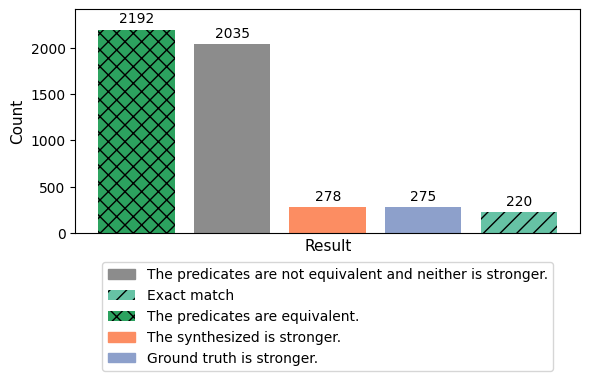

In [35]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Assuming 'comparison_results' is already defined and is a DataFrame
data = pd.DataFrame.from_dict(comparison_results[0:5000])

# Calculate the result distribution
result_distribution = data['result'].value_counts()

# Define the updated color palette and use a pattern for the "Exact Match" bar
color_map_updated = {
    "The predicates are not equivalent and neither is stronger.": "#8c8c8c",
    "Exact Match": "#66c2a5",
    "The predicates are equivalent.": "#2ca25f",
    "The second predicate is stronger.": "#fc8d62",
    "The first predicate is stronger.": "#8da0cb"
}

# Create the bar plot with the updated color scheme and add patterns for specified bars
plt.figure(figsize=(6, 4))
bars = plt.bar(result_distribution.index, result_distribution.values, color=[color_map_updated.get(result, 'gray') for result in result_distribution.index])

# Add patterns to the "Exact Match" and "The predicates are equivalent." bars
for bar, label in zip(bars, result_distribution.index):
    if label == "Exact Match":
        bar.set_hatch('//')
    elif label == "The predicates are equivalent.":
        bar.set_hatch('xx')

# Adjust the y-axis limits to add space above the bars
plt.ylim(0, max(result_distribution.values) * 1.1)

# Add numbers on top of the bars with a smaller font size
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (max(result_distribution.values) * 0.02), int(yval), ha='center', va='bottom', fontsize=10)

# Set the labels with specified font sizes
plt.xlabel('Result', fontsize=11)
plt.ylabel('Count', fontsize=11)

# Remove x labels and add a legend below the plot with specified font size and updated labels
plt.xticks([])
legend_labels = [
    mpatches.Patch(color="#8c8c8c", label="The predicates are not equivalent and neither is stronger."),
    mpatches.Patch(facecolor="#66c2a5", hatch='//', label="Exact match"),
    mpatches.Patch(facecolor="#2ca25f", hatch='xx', label="The predicates are equivalent."),
    mpatches.Patch(color="#fc8d62", label="The synthesized is stronger."),
    mpatches.Patch(color="#8da0cb", label="Ground truth is stronger.")
]
plt.legend(handles=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1, fontsize=10)

# Adjust layout and save the plot as PDF with a suitable size for ACM papers
plt.tight_layout()
plt.savefig('match_results_distribution_acm_light.pdf')
plt.show()


## New one

In [121]:
# %% Helper: derive FIM prefix/suffix from the 'input' field
MASK_TOKENS = ["<FILL_ME>", "<MASK>", "<HOLE>", "§MASK§"]

def split_mask(text: str):
    """Return (prefix, suffix) if a known mask token is found in text; else (None, None)."""
    if not isinstance(text, str):
        return (None, None)
    for tok in MASK_TOKENS:
        pos = text.find(tok)
        if pos != -1:
            return text[:pos], text[pos+len(tok):]
    # also handle case-insensitive <fill_me> variants
    m = re.search(r"<\s*FILL\s*_?\s*ME\s*>", text, flags=re.I)
    if m:
        start, end = m.span()
        return text[:start], text[end:]
    return (None, None)



In [122]:
# %% Batch generation template (FIM-first)
OUT_COL     = "results DeepSeek"

# Use your actual DF; you showed a head like this:
# columns: ['comment','input','label','original_idx','predicate','len','results']
_df = ten_of_100k_head.copy()   # or df_100k.iloc[...].copy()

rows = _df.shape[0]
print(f"Running DeepSeek (FIM-first) on {rows} rows...")

preds = []
for i, row in _df.iterrows():
    try:
        raw_input = row.get("input", "")
        prefix, suffix = split_mask(raw_input)

        if prefix is not None:  # FIM path
            pred = deepseek_fim(prefix, suffix)
            print(f"[FIM] row {i}: {pred}")
        else:
            # Fallback prompt if your 'input' lacks a mask token
            # Use any extra context you like (comment, function, etc.)
            ctx = (
                f"Fill the missing predicate in: require(<FILL_ME>); "
                f"Context: {raw_input}\n"
                f"Hint: {row.get('comment','')}"
            )
            pred = deepseek_chat(ctx)
            print(f"[Chat-fallback] row {i}: {pred}")

        preds.append(pred)
    except Exception as e:
        print(f"  [!] Error row {i}: {e}")
        preds.append(None)

# assign safely
_df.loc[:, OUT_COL] = preds
print("Done. Wrote column:", OUT_COL)


Running DeepSeek (FIM-first) on 4900 rows...
[FIM] row 100: maxRoundSupply[_round] > 0 &&
[FIM] row 101: !isliveed[sender],"live")
[FIM] row 102: qualifiedWalletList[msg.sender] + amount_ <= MINT_LIMIT_PER_ADDRESS, "Minting limit exceeded"
[FIM] row 103: msg.sender == address(_controller), "!controller"
[FIM] row 104: _value <= balances[msg.sender]
[FIM] row 105: isOnCollectionAllowlist || realm.constraints.allowAllCollections, "invalid collection")
[FIM] row 106: amount_ > 0, "MBLK: amount should be greater than 0")
[FIM] row 107: totalSupply() < MAX_SUPPLY, "Reincarnation: Max supply reached"
[FIM] row 108: _drop.maxQuantityPerSale == 0 || (_drop.maxQuantityPerSale != 0 && quantity <= _drop.maxQuantityPerSale),
[FIM] row 109: erc721.ownerOf(_tokenId) == msg.sender, "Not owner"
[FIM] row 110: numberOfLevels > 0, "Must evolve at least one level!")
[FIM] row 111: _strategies.length == withdrawalsPercents.length, 'Zunami: arrays not equal'
[FIM] row 112: _balanceOf[to] + value > _balance

In [127]:
# save _df in a file
_df.to_csv("deepseek_inference_results.csv", index=False)

## Evaluation

In [124]:

# %% Evaluation: compare ground_truth 'predicate' vs DeepSeek predictions
from sindi.comparator import Comparator
import pandas as pd
from tqdm import tqdm
cmp = Comparator()

if 'predicate' not in _df.columns or 'results DeepSeek' not in _df.columns:
    raise RuntimeError("Expected columns 'predicate' and 'results DeepSeek'. Configure earlier cells if different.")

comparison_results_deepseek = []
sindi_failures_deepseek = []

for i, row in tqdm(_df.iterrows(), total=_df.shape[0], desc="Comparing predicates (DeepSeek)"):
    gt = (row.get('predicate') or '').strip()
    syn = (row.get('results DeepSeek') or '').strip()
    if not gt or not syn:
        sindi_failures_deepseek.append({'index': i, 'ground_truth': gt, 'synthesized': syn, 'exception': 'empty'})
        comparison_results_deepseek.append({'original_index': i, 'ground_truth': gt, 'synthesized': syn, 'result': 'N/A'})
        continue
    if gt == syn:
        comparison_results_deepseek.append({'original_index': i, 'ground_truth': gt, 'synthesized': syn, 'result': 'Exact Match'})
        continue
    try:
        r = cmp.compare(gt, syn)
        comparison_results_deepseek.append({'original_index': i, 'ground_truth': gt, 'synthesized': syn, 'result': r})
    except Exception as e:
        comparison_results_deepseek.append({'original_index': i, 'ground_truth': gt, 'synthesized': syn, 'result': 'The predicates are not equivalent and neither is stronger.'})
        sindi_failures_deepseek.append({'index': i, 'ground_truth': gt, 'synthesized': syn, 'exception': str(e)})


pd.DataFrame(comparison_results_deepseek).to_csv("deepseek_comparison_results.csv", index=False)
print("Saved deepseek_comparison_results.csv with", len(comparison_results_deepseek), "rows")


Comparing predicates (DeepSeek): 100%|██████████| 4900/4900 [04:54<00:00, 16.65it/s]

Saved deepseek_comparison_results.csv with 4900 rows


In [132]:
import re

RE_REQUIRE_WRAP = re.compile(r'^\s*require\s*\(\s*(.*?)\s*\)\s*;?\s*$', re.S)
RE_LINE_COMMENT = re.compile(r'//.*?$', re.M)
RE_BLOCK_COMMENT= re.compile(r'/\*.*?\*/', re.S)
RE_HEX_ADDR     = re.compile(r'0x[0-9a-fA-F]+')
RE_NUMERIC_TOKEN = re.compile(r'(?<![A-Za-z_])(\d[\d_]*)(?![A-Za-z_])')

def _strip_outer_parens(s: str) -> str:
    if not s or s[0] != '(' or s[-1] != ')': return s
    depth = 0
    for i, ch in enumerate(s):
        if ch == '(': depth += 1
        elif ch == ')':
            depth -= 1
            if depth == 0 and i != len(s) - 1:
                return s
    return s[1:-1]

def normalize_predicate_for_exact(expr: str) -> str:
    if expr is None: return ""
    s = str(expr).strip()
    m = RE_REQUIRE_WRAP.match(s)
    if m: s = m.group(1)
    s = RE_BLOCK_COMMENT.sub("", s)
    s = RE_LINE_COMMENT.sub("", s)
    s = RE_HEX_ADDR.sub(lambda m: m.group(0).lower(), s)
    s = re.sub(r'\bTRUE\b', 'true', s); s = re.sub(r'\bTrue\b', 'true', s)
    s = re.sub(r'\bFALSE\b','false', s); s = re.sub(r'\bFalse\b','false', s)
    s = RE_NUMERIC_TOKEN.sub(lambda m: m.group(1).replace('_',''), s)
    for _ in range(3):
        ns = _strip_outer_parens(s.strip())
        if ns == s: break
        s = ns
    s = re.sub(r'\s+', '', s).rstrip(';')
    return s


In [ ]:
from sindi.comparator import Comparator
import pandas as pd
from tqdm import tqdm

cmp = Comparator()

if 'predicate' not in _df.columns or 'results DeepSeek' not in _df.columns:
    raise RuntimeError("Expected columns 'predicate' and 'results DeepSeek'. Configure earlier cells if different.")

comparison_results_deepseek = []
sindi_failures_deepseek = []

# Read the comparison results from CSV
df_eval = pd.read_csv("deepseek_comparison_results_0-4999.csv")

for i, row in tqdm(df_eval.iterrows(), total=df_eval.shape[0], desc="Comparing predicates (DeepSeek, normalized)"):
    gt_raw  = (row.get('ground_truth') or '').strip()
    syn_raw = (row.get('synthesized') or '').strip()
    
    if "," in syn_raw:
        syn_raw = syn_raw.split(',')[0]
        if syn_raw.startswith('"'):
            syn_raw = syn_raw[1:-1]
    
    if not gt_raw or not syn_raw:
        sindi_failures_deepseek.append({'index': i, 'ground_truth': gt_raw, 'synthesized': syn_raw, 'exception': 'empty'})
        comparison_results_deepseek.append({'original_index': i, 'ground_truth': gt_raw, 'synthesized': syn_raw, 'result': 'N/A'})
        continue


    gt_norm  = normalize_predicate_for_exact(gt_raw)
    syn_norm = normalize_predicate_for_exact(syn_raw)

    if gt_norm == syn_norm:
        comparison_results_deepseek.append({
            'original_index': i,
            'ground_truth': gt_raw,
            'synthesized': syn_raw,
            'result': 'Exact Match'
        })
        continue

    # Fall back to semantic comparison
    try:
        r = cmp.compare(gt_raw, syn_raw)
        comparison_results_deepseek.append({'original_index': i, 'ground_truth': gt_raw, 'synthesized': syn_raw, 'result': r})
    except Exception as e:
        comparison_results_deepseek.append({'original_index': i, 'ground_truth': gt_raw, 'synthesized': syn_raw, 'result': 'The predicates are not equivalent and neither is stronger.'})
        sindi_failures_deepseek.append({'index': i, 'ground_truth': gt_raw, 'synthesized': syn_raw, 'exception': str(e)})

pd.DataFrame(comparison_results_deepseek).to_csv("deepseek_comparison_results.csv", index=False)
print("Saved deepseek_comparison_results.csv with", len(comparison_results_deepseek), "rows")

Comparing predicates (DeepSeek, normalized): 100%|██████████| 5000/5000 [03:10<00:00, 26.28it/s]

Saved deepseek_comparison_results.csv with 5000 rows


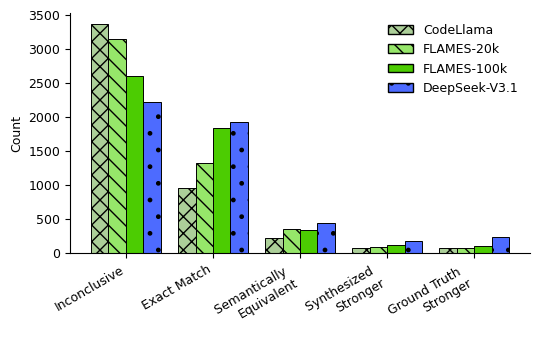

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Categories
categories = [
    "Inconclusive",
    "Exact Match",
    "Semantically \nEquivalent",
    "Synthesized \nStronger",
    "Ground Truth \nStronger"
]

# Data
code_llama = [3363, 959, 217, 81, 76]
flames_2ok = [3142, 1328, 362, 94, 74]
flames_100k = [2595, 1840, 334, 125, 106]
deepseek = [2217, 1930, 439, 174, 240]

x = np.arange(len(categories))
width = 0.2

# Colors: blue for CodeLlama, green shades for FLAMES, and a new color for DeepSeek
#colors = ['#4E79A7', '#7FBF7F', '#2C7C2C', '#4d6bff']  # Added orange for DeepSeek
colors = ['#accf99', '#96e66a', '#4ccc02', '#4d6bff']  # Added orange for DeepSeek
hatches = ['XX', '\\\\', '', '.'] # Added dots for DeepSeek

# Plot
fig, ax = plt.subplots(figsize=(5.5, 3.5))

# Adjust bar positions to center the group
bars1 = ax.bar(x - 1.5*width, code_llama, width, label='CodeLlama', color=colors[0], hatch=hatches[0], edgecolor='black', linewidth=0.7)
bars2 = ax.bar(x - 0.5*width, flames_2ok, width, label='FLAMES-20k', color=colors[1], hatch=hatches[1], edgecolor='black', linewidth=0.7)
bars3 = ax.bar(x + 0.5*width, flames_100k, width, label='FLAMES-100k', color=colors[2], hatch=hatches[2], edgecolor='black', linewidth=0.7)
bars4 = ax.bar(x + 1.5*width, deepseek, width, label='DeepSeek-V3.1', color=colors[3], hatch=hatches[3], edgecolor='black', linewidth=0.7)


# Axes settings
ax.set_ylabel('Count', fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=9, rotation=30, ha='right')
ax.tick_params(axis='y', labelsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# Legend
legend_labels = ['CodeLlama', 'FLAMES-20k', 'FLAMES-100k', 'DeepSeek-V3.1']
legend_patches = [
    mpatches.Patch(facecolor=colors[i], hatch=hatches[i], edgecolor='black', label=label)
    for i, label in enumerate(legend_labels)
]
ax.legend(handles=legend_patches, fontsize=9, loc='upper right', frameon=False)
fig.savefig("predicate_comparison_with_deepseek.pdf", format="pdf", bbox_inches="tight")

fig.tight_layout()
plt.show()

## Same thing without codellama 

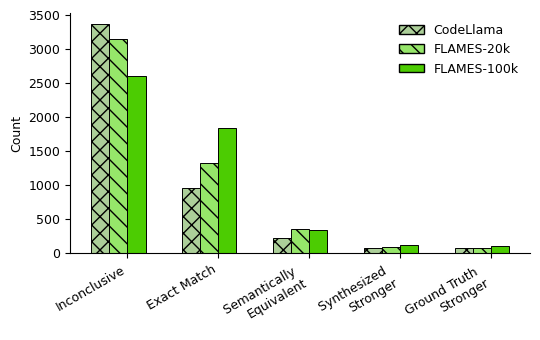

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Categories
categories = [
    "Inconclusive",
    "Exact Match",
    "Semantically \nEquivalent",
    "Synthesized \nStronger",
    "Ground Truth \nStronger"
]

# Data
code_llama = [3363, 959, 217, 81, 76]
flames_2ok = [3142, 1328, 362, 94, 74]
flames_100k = [2328, 1840, 386, 209, 237]
#deepseek = [2217, 1930, 439, 174, 240]

x = np.arange(len(categories))
width = 0.2

# Colors: blue for CodeLlama, green shades for FLAMES, and a new color for DeepSeek
#colors = ['#4E79A7', '#7FBF7F', '#2C7C2C', '#4d6bff']  # Added orange for DeepSeek
colors = ['#accf99', '#96e66a', '#4ccc02', '#4d6bff']  # Added orange for DeepSeek
hatches = ['XX', '\\\\', '', '.'] # Added dots for DeepSeek

# Plot
fig, ax = plt.subplots(figsize=(5.5, 3.5))

# Adjust bar positions to center the group
bars1 = ax.bar(x - 1.5*width, code_llama, width, label='CodeLlama', color=colors[0], hatch=hatches[0], edgecolor='black', linewidth=0.7)
bars2 = ax.bar(x - 0.5*width, flames_2ok, width, label='FLAMES-20k', color=colors[1], hatch=hatches[1], edgecolor='black', linewidth=0.7)
bars3 = ax.bar(x + 0.5*width, flames_100k, width, label='FLAMES-100k', color=colors[2], hatch=hatches[2], edgecolor='black', linewidth=0.7)
#bars4 = ax.bar(x + 1.5*width, deepseek, width, label='DeepSeek-V3.1', color=colors[3], hatch=hatches[3], edgecolor='black', linewidth=0.7)


# Axes settings
ax.set_ylabel('Count', fontsize=9)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=9, rotation=30, ha='right')
ax.tick_params(axis='y', labelsize=9)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)

# Legend
legend_labels = ['CodeLlama', 'FLAMES-20k', 'FLAMES-100k']
legend_patches = [
    mpatches.Patch(facecolor=colors[i], hatch=hatches[i], edgecolor='black', label=label)
    for i, label in enumerate(legend_labels)
]
ax.legend(handles=legend_patches, fontsize=9, loc='upper right', frameon=False)
fig.savefig("predicate_comparison_without_deepseek.pdf", format="pdf", bbox_inches="tight")

fig.tight_layout()
plt.show()

Compilability

/var/folders/hd/3r4ph2yd3v17l1p5f3smzm640000gp/T/ipykernel_22563/454562505.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories, fontsize=7, rotation=25, ha="right")


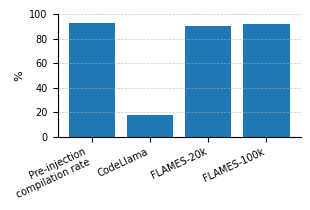

In [6]:
import matplotlib.pyplot as plt

# Data
categories = ["Pre-injection\ncompilation rate", "CodeLlama", "FLAMES-20k", "FLAMES-100k"]
values = [92.3, 17.8, 90.5, 92.0]

# Create figure
fig, ax = plt.subplots(figsize=(3.2, 2.2))  # compact size suitable for ACM double-column

# Bar plot
bars = ax.bar(categories, values)

# Formatting
ax.set_ylim(0, 100)
ax.set_ylabel("%", fontsize=8)
ax.set_xticklabels(categories, fontsize=7, rotation=25, ha="right")
ax.tick_params(axis="y", labelsize=7)
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)

# Remove spines for cleaner ACM style
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


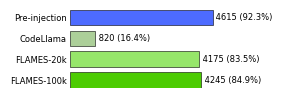

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data in desired top-to-bottom order
categories = ["Pre-injection", "CodeLlama", "FLAMES-20k", "FLAMES-100k"]
values = [4615, 820, 4175, 4245]
total = 5000

# Color & hatch profile
colors = ['#4d6bff', '#accf99', '#96e66a', '#4ccc02']


# Super-compact figure sized for ACM column usage
fig, ax = plt.subplots(figsize=(3, 0.9))

# Custom y positions with near-touching bars
y = np.arange(len(categories))
bar_height = 0.75

# Draw bars with cyclical colors and hatches
bar_colors = [colors[i % len(colors)] for i in range(len(categories))]
bars = ax.barh(y, values, height=bar_height, color=bar_colors, edgecolor='black', linewidth=0.4)


# Y-axis labels (right-aligned)
ax.set_yticks(y)
ax.set_yticklabels(categories, fontsize=6)
for lbl in ax.get_yticklabels():
    lbl.set_horizontalalignment('right')
ax.tick_params(axis='y', pad=2, length=0)

# Remove x-axis ticks/labels/grid
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False, length=0)
ax.grid(False)

# Remove all spines
for spine in ["top", "right", "bottom", "left"]:
    ax.spines[spine].set_visible(False)

# Tight vertical margins so bars fill the plot area
ax.set_ylim(-0.5 + (1-bar_height)/2, len(categories)-0.5 - (1-bar_height)/2)
ax.invert_yaxis()  # Keep list order top->bottom
ax.margins(x=0.01, y=0.0)

# Percentage labels right after the bar ends
for yi, v in zip(y, values):
    percentage = (v / total) * 100
    ax.text(v + 20, yi, f" {int(v)} ({percentage:.1f}%)", va='center', fontsize=6)


# Slight headroom for labels at right
ax.set_xlim(0, max(values) + 800)

# Ensure enough left margin so right-aligned y-labels aren't clipped
plt.subplots_adjust(left=0.42, right=0.98, top=0.95, bottom=0.08)

# Create a directory if it doesn't exist
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

plt.savefig('figures/compilation-rate.pdf', bbox_inches='tight')

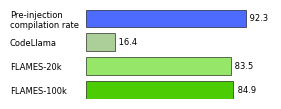

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data in desired top-to-bottom order
categories = ["Pre-injection", "CodeLlama", "FLAMES-20k", "FLAMES-100k"]
values = [92.3, 16.4, 83.5, 84.9]

# Color profile
colors = ['#4d6bff', '#accf99', '#96e66a', '#4ccc02']

# Super-compact figure sized for ACM column usage
fig, ax = plt.subplots(figsize=(2.6, 0.9))

# Custom y positions with near-touching bars
y = np.arange(len(categories))
bar_height = 0.75

# Draw bars
bar_colors = [colors[i % len(colors)] for i in range(len(categories))]
bars = ax.barh(y, values, height=bar_height, color=bar_colors, edgecolor='black', linewidth=0.4)

# Y-axis labels (LEFT-aligned)
ax.set_yticks(y)
ax.set_yticklabels(categories, fontsize=6)
for lbl in ax.get_yticklabels():
    lbl.set_horizontalalignment('left')
ax.tick_params(axis='y', pad=55, length=0)  # super tight

# Remove x-axis ticks/labels/grid
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False, length=0)
ax.grid(False)

# Remove all spines
for spine in ["top", "right", "bottom", "left"]:
    ax.spines[spine].set_visible(False)

# Tight vertical margins so bars fill the plot area
ax.set_ylim(-0.5 + (1-bar_height)/2, len(categories)-0.5 - (1-bar_height)/2)
ax.invert_yaxis()  # Keep list order top->bottom
ax.margins(x=0.0, y=0.0)

# Percentage labels just after the bar ends (minimal right margin)
for yi, v in zip(y, values):
    ax.text(v + 0.6, yi, f" {v:.1f} ", va='center', fontsize=6)

# Minimal headroom on the right for labels
ax.set_xlim(0, max(values) + 2.2)

# Use the whole canvas; bbox_inches will preserve labels
plt.subplots_adjust(left=0.0, right=1.0, top=0.98, bottom=0.02)
plt.tight_layout(pad=0.02)

# Save vector + bitmap
pdf_path = "figures/compilation-rate.pdf"
plt.savefig(pdf_path, bbox_inches='tight', pad_inches=0.01)

plt.show()